<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook evaluates the frozen features of a ResNet50 pre-trained (50 epochs of pre-training) using the [SimSiam method](https://arxiv.org/abs/2011.10566). You can refer to the [pre-training notebook here](https://github.com/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb). Following evaluation methods have been used - 

* Linear evaluation of the frozen features

*Please note that to keep this minimal I did not follow the original hyperparameter configurations rigorously.*  

## Initial setup

In [1]:
!nvidia-smi

Sun Dec  5 20:34:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8     2W /  N/A |    182MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

tf.random.set_seed(666)
np.random.seed(666)

In [5]:
# Retrieve the weights (50 epochs pre-training) of the projection head
!wget -q https://github.com/sayakpaul/SimSiam-TF/releases/download/v1.0.0/projection.h5

## Dataset collection & preparation

The following code is referred from [here](https://github.com/ayulockin/SwAV-TF/blob/master/linear_evaluation/Linear_Evaluation_10_Epochs.ipynb). 

In [6]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Utility functions

In [7]:
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

In [8]:
get_encoder().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4194304   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2048)              419635

In [9]:
# We now load up the pre-trained weights
projection = get_encoder()
projection.load_weights('projection.h5')

# Create a sub-model for extracting features
rn50 = tf.keras.Model(projection.input, projection.layers[2].output)
rn50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
def get_linear_classifier(feature_backbone, trainable=False):
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    feature_backbone.trainable = trainable
    x = feature_backbone(inputs, training=False)
    outputs = tf.keras.layers.Dense(5, activation="softmax", )(x)
    linear_model = tf.keras.Model(inputs, outputs)

    return linear_model

In [11]:
get_linear_classifier(rn50).summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

## Linear evaluation

In [13]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=5, verbose=2, 
                                                 restore_best_weights=True)

Epoch 1/100
49/49 [==============================] - 17s 216ms/step - loss: 1.7460 - accuracy: 0.2958 - val_loss: 1.6271 - val_accuracy: 0.2709
Epoch 2/100
49/49 [==============================] - 8s 162ms/step - loss: 1.5285 - accuracy: 0.3372 - val_loss: 1.5551 - val_accuracy: 0.3018
Epoch 3/100
49/49 [==============================] - 8s 162ms/step - loss: 1.4987 - accuracy: 0.3593 - val_loss: 1.5205 - val_accuracy: 0.3382
Epoch 4/100
49/49 [==============================] - 8s 163ms/step - loss: 1.4730 - accuracy: 0.3795 - val_loss: 1.4995 - val_accuracy: 0.3491
Epoch 5/100
49/49 [==============================] - 8s 163ms/step - loss: 1.4478 - accuracy: 0.3920 - val_loss: 1.4868 - val_accuracy: 0.3491
Epoch 6/100
49/49 [==============================] - 8s 163ms/step - loss: 1.4246 - accuracy: 0.4019 - val_loss: 1.4766 - val_accuracy: 0.3473
Epoch 7/100
49/49 [==============================] - 8s 164ms/step - loss: 1.4033 - accuracy: 0.4167 - val_loss: 1.4671 - val_accuracy: 0.354

Epoch 58/100
49/49 [==============================] - 9s 182ms/step - loss: 1.0213 - accuracy: 0.6231 - val_loss: 1.3060 - val_accuracy: 0.4545
Epoch 59/100
49/49 [==============================] - 9s 182ms/step - loss: 1.0172 - accuracy: 0.6253 - val_loss: 1.3053 - val_accuracy: 0.4545
Epoch 60/100
49/49 [==============================] - 9s 179ms/step - loss: 1.0132 - accuracy: 0.6269 - val_loss: 1.3046 - val_accuracy: 0.4564
Epoch 61/100
49/49 [==============================] - 9s 184ms/step - loss: 1.0092 - accuracy: 0.6276 - val_loss: 1.3040 - val_accuracy: 0.4564
Epoch 62/100
49/49 [==============================] - 9s 181ms/step - loss: 1.0053 - accuracy: 0.6304 - val_loss: 1.3034 - val_accuracy: 0.4564
Epoch 63/100
49/49 [==============================] - 9s 180ms/step - loss: 1.0015 - accuracy: 0.6330 - val_loss: 1.3028 - val_accuracy: 0.4564
Epoch 64/100
49/49 [==============================] - 9s 187ms/step - loss: 0.9976 - accuracy: 0.6343 - val_loss: 1.3022 - val_accuracy:

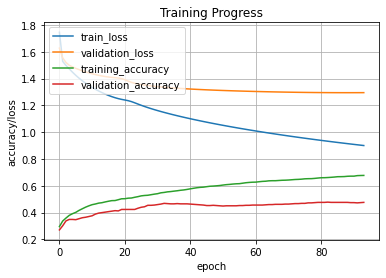

In [14]:
# Get linear model and compile
tf.keras.backend.clear_session()
model = get_linear_classifier(rn50)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")

# Train 
history = model.fit(training_ds,
                 validation_data=validation_ds,
                 epochs=100,
                 callbacks=[early_stopper])
plot_progress(history)

In [15]:
_, acc = model.evaluate(validation_ds)
print('Validation accuracy:', round(acc*100, 2))

9/9 [==============================] - 12s 1s/step - loss: 1.2950 - accuracy: 0.4764
Validation accuracy: 47.64


For a minimal implementation the scores aren't that bad. 